In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

# SELLER P&L ANALYSIS

The goal of this exercise is to compute, for each `seller_id`:

- The **revenue** it brings (10% of each sales + 80 BRL per month)
- The **cost** associated with all its bad reviews (1-star = 100 BRL, 2-star = 50, 3-star=40)
- The resulting **profit** made by Olist for each seller

❓ Let's not start all again from scratch! Import your seller training set and investigate what you already have.


In [2]:
from olist.seller import Seller
seller = Seller()

In [3]:
sellers = seller.get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_of_one_stars,share_of_five_stars,review_score,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,0.333333,0.333333,3.00,3,3,1.000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,0.050000,0.725000,4.55,40,41,1.025,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.000000,1.000000,5.00,1,1,1.000,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.000000,1.000000,5.00,1,1,1.000,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,1.000000,0.000000,1.00,1,1,1.000,167.99


❓ What is missing? Write down a strategy to get your missing columns, by re-using as much of  what has already been coded in `seller.py` as possible

In [4]:
# Your pseudo-code

❓ Update `seller.py` accordingly

Correction below, updated in `seller_updated.py`

TODO: Show students how to update their code and print results in their notebook. Debug using ipdb.set_trace() when needed

```python
def get_review_score(self):

        matching_table = self.matching_table
        orders_reviews = self.order.get_review_score()
        matching_table = matching_table[['order_id', 'seller_id']].drop_duplicates()
        df = matching_table.merge(orders_reviews, on='order_id')

        # Compute the costs
        df['cost_of_review'] = df.review_score.map({
            1: 100,
            2: 50,
            3: 40,
            4: 0,
            5: 0
        })

        df = df.groupby('seller_id',
                        as_index=False).agg({'dim_is_one_star': 'mean',
                                             'dim_is_five_star': 'mean',
                                             'review_score': 'mean',
                                             'cost_of_review': 'sum'}) # new column added here
        df.columns = ['seller_id', 'share_of_one_stars',
                      'share_of_five_stars', 'review_score', 'cost_of_reviews']

        return df

❓ Compute seller profits

updated code below

```python
def get_training_data(self):

    training_set =\
        self.get_seller_features()\
            .merge(
            self.get_seller_delay_wait_time(), on='seller_id'
           ).merge(
            self.get_active_dates(), on='seller_id'
           ).merge(
            self.get_review_score(), on='seller_id'
           ).merge(
            self.get_quantity(), on='seller_id'
           ).merge(
            self.get_sales(), on='seller_id'
           )
    # Add seller economics (revenues, profits)
    olist_monthly_fee = 80
    olist_sales_cut = 0.1

    training_set['revenues'] = training_set['months_on_olist'] * olist_monthly_fee\
        + olist_sales_cut * training_set['sales']

    training_set['profits'] = training_set['revenues'] - training_set['cost_of_reviews']

    return training_set
```

❓ Load your updated DataFrame

In [5]:
from olist.seller_updated import Seller as SellerUpdated
sellers = SellerUpdated().get_training_data()

❓ Sort sellers by profit, and analyse their profitability: conclude on a possible strategy for Olist!

Text(0.5, 0, 'seller id')

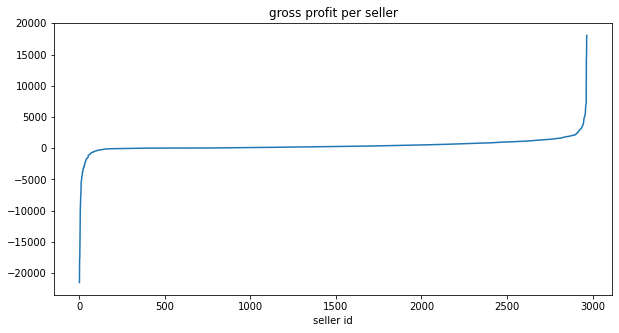

In [6]:
sorted_sellers = sellers.sort_values(by='profits')[['profits', 'n_orders', 'revenues']].reset_index()
sorted_sellers.head()

plt.figure(figsize=(10,5))
sorted_sellers.profits.plot()
plt.title('gross profit per seller')
plt.xlabel('seller id')

# Going further

## Profits per seller removed before IT costs

We should look at the effect of removing sellers on the total profits of Olist.

### Total profits for Olist
Let's first calculate Olist's total profits.

In [7]:
olist_total_profits = sorted_sellers.profits.sum()

print(f"Olist's total profits were BRL {olist_total_profits:,.0f}.")

Olist's total profits were BRL 1,167,608.


### Cumulative profits from sellers

What are the profits when we add each seller one by one (from worst to best)?

<AxesSubplot:title={'center':'Cumulative profits from sellers'}, xlabel='No of sellers on Olist (from worst to best)', ylabel='Cumulative profits (in millions of BRL)'>

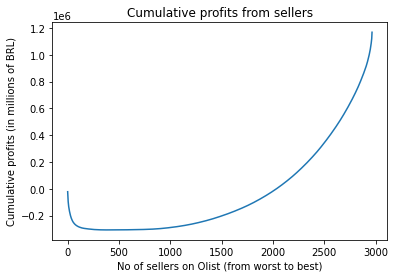

In [8]:
sorted_sellers.cumsum().profits.plot(title="Cumulative profits from sellers",
                                     xlabel="No of sellers on Olist (from worst to best)",
                                     ylabel="Cumulative profits (in millions of BRL)")

☝️ This shows that Olist loses money with about 300 of its worst performing sellers. They need the 2000 "worst" performing sellers to break even.

Let's look at it the other way around. Olist's total profits were BRL 1,167,608. What if we removed the worst sellers one by one?

<AxesSubplot:title={'center':'Profits per removed seller (before it costs)'}, xlabel='No of removed seller (from worst to best)', ylabel='Total Olist profits (in millions of BRL)'>

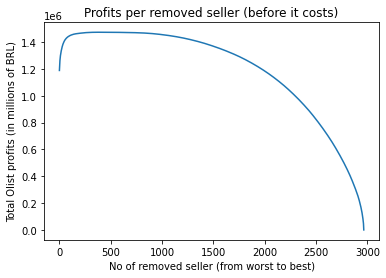

In [9]:
profits_per_removed_seller_before_it_costs = olist_total_profits - sorted_sellers.cumsum().profits

profits_per_removed_seller_before_it_costs.plot(title="Profits per removed seller (before it costs)",
                                               xlabel="No of removed seller (from worst to best)",
                                               ylabel="Total Olist profits (in millions of BRL)")

Let's define a function to plot the maximum of that curve:

In [10]:
def plot_max(series):
    max_idx = series.idxmax()
    max_value = series.iloc[max_idx]
    plt.scatter(max_idx, max_value, color="red")
    plt.text(max_idx, 0, f"Max:\n{max_value:.2f}\nfor index {max_idx}")
    return max_idx, max_value

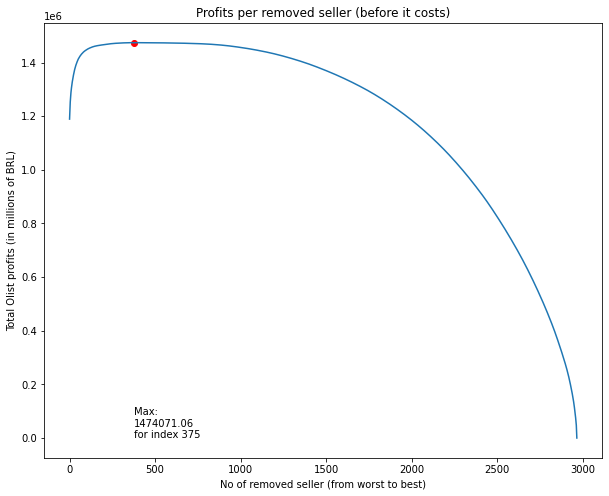

In [11]:
# Plot the cumulative sum curve
plt.figure(figsize=(10,8))
profits_per_removed_seller_before_it_costs.plot(title="Profits per removed seller (before it costs)",
                                               xlabel="No of removed seller (from worst to best)",
                                               ylabel="Total Olist profits (in millions of BRL)")

# Plot the max profits as a single dot
max_idx, max_value = plot_max(profits_per_removed_seller_before_it_costs)

## Let's factor in the IT costs

Firstly, we can translate what we did for the profits to the number of orders `n_orders`. This gives us the total number of orders per seller removed.

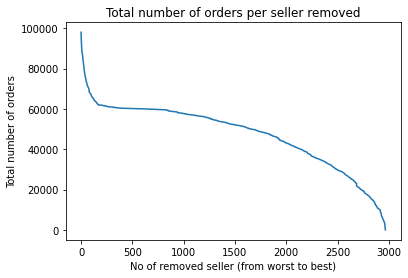

In [12]:
# Total number of orders
olist_total_orders = sorted_sellers.n_orders.sum()

# Orders per removed seller
n_orders_per_removed_seller = olist_total_orders - sorted_sellers.cumsum().n_orders
n_orders_per_removed_seller.plot(title="Total number of orders per seller removed",
                                 xlabel="No of removed seller (from worst to best)",
                                 ylabel="Total number of orders");

### Calculating the new corresponding IT costs

From the challenge instructions:
> For the sake of simplicity, we will consider Olist’s total cumulated IT Costs to be proportional to the square-root of the total cumulated number of orders approved.

Which translates to this formula, with $\alpha$ being a proportionality factor (constant):

$ costs_{IT} = \alpha * \sqrt{n_{orders}} $

We are also given this information:
> The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to 500,000 BRL.

So we can calculate the proportionality factor $\alpha$.

$ \alpha = \frac{costs_{IT}}{\sqrt{n_{orders}}} $

In [13]:
# Proportionality factor
total_it_costs = 500_000
# total_it_costs = alpha * olist_total_orders ** 0.5
alpha = 500_000 / olist_total_orders ** 0.5
alpha

1582.3973364219244

We can now calculate the new associated IT costs per removed seller (based on the number of orders per removed seller).

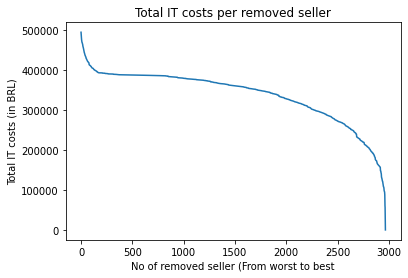

In [14]:
# IT costs per removed seller
total_it_costs_per_removed_seller = alpha * n_orders_per_removed_seller ** 0.5

total_it_costs_per_removed_seller.plot(title="Total IT costs per removed seller",
                                       xlabel="No of removed seller (From worst to best",
                                       ylabel="Total IT costs (in BRL)");

Finally, we can calculate the real profits per removed seller, _i.e._ after IT costs.

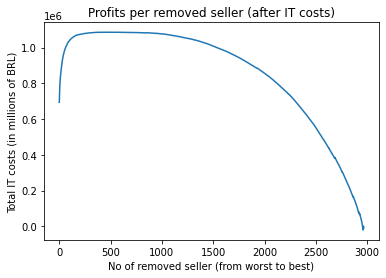

In [15]:
# Profits per removed seller after IT costs
profits_per_removed_seller = profits_per_removed_seller_before_it_costs - total_it_costs_per_removed_seller
profits_per_removed_seller.plot(title="Profits per removed seller (after IT costs)",
                                       xlabel="No of removed seller (from worst to best)",
                                       ylabel="Total IT costs (in millions of BRL)");

### Profit margin

Lastly, we can now get the profit margin of Olist based on the number of sellers removed:

(485, 0.38966835275617917)

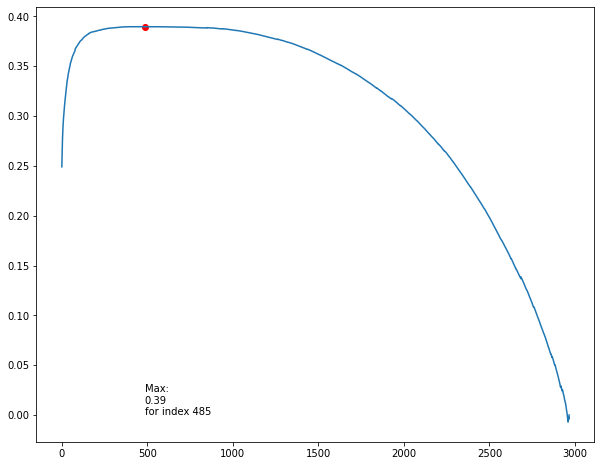

In [16]:
# Revenues per seller
revenues_per_removed_seller =  sorted_sellers.revenues.sum()

# Profit margins
profit_margins_per_removed_seller = profits_per_removed_seller / revenues_per_removed_seller

plt.figure(figsize=(10,8))
profit_margins_per_removed_seller.plot()
plot_max(profit_margins_per_removed_seller)

This above means that the maximum profit margins for Olist would have been achieved if 485 of the worst performing sellers had never joined the platform.